# Summary
Here we do a validation of the 'simple' jaccard correlations by repeating some of the Spec2Vec metrics. Much of the code is directly copied from Florian's notebooks here https://github.com/iomega/spec2vec_gnps_data_analysis/blob/master/notebooks/

MDs are added to SpectrumDocument as 'md@...'. Intensity (for now) is sqrt(count) * max_intensity with a maximum of 1.

In [1]:
import os
import gensim
import pickle
import time
import sys
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from typing import Tuple, List
from copy import deepcopy

data_path = "/mnt/scratch/louwe015/Mass_differences/data/"

In [2]:
all_pos_version1 = False
if all_pos_version1:
    all_pos = "gnps_positive_ionmode_cleaned_by_matchms_and_lookups"
else:
    all_pos = "ALL_GNPS_210125_positive_cleaned_by_matchms_and_lookups"

print(all_pos)

ALL_GNPS_210125_positive_cleaned_by_matchms_and_lookups


In [3]:
if all_pos_version1:
    jacc_mat_file = None  # I didn't run this one
else:
    jacc_mat_file = "jaccard_matrix_allpos2_04-03-2021.npz"

jacc_mat_path = os.path.join(data_path, 'jaccard_matrices', jacc_mat_file)
print(jacc_mat_file, os.path.isfile(jacc_mat_path))

jaccard_matrix_allpos2_04-03-2021.npz True


## Load jaccard matrix and get MDs with correlations 0.1-0.5

In [41]:
low_cutoff = 0.1
high_cutoff = 0.5

In [6]:
jacc_mat_npz = np.load(jacc_mat_path, allow_pickle=True)

In [9]:
j_rows, j_cols, jacc_mat_sparse = [jacc_mat_npz[name] for name in jacc_mat_npz.files]
jacc_mat_sparse = jacc_mat_sparse.item()

In [27]:
jacc_mat_sparse

<61348x115913 sparse matrix of type '<class 'numpy.float64'>'
	with 384463253 stored elements in Compressed Sparse Row format>

In [34]:
maxes = jacc_mat_sparse.max(axis=1).toarray()

In [42]:
maxes_inds = [i for i, val in enumerate(maxes) if val[0] >= low_cutoff and val[0] <= high_cutoff]

In [45]:
maxes[:5], maxes_inds[:5]  # seems to have worked

(array([[0.13313639],
        [0.24642122],
        [0.1013701 ],
        [0.09151063],
        [0.08100498]]),
 [0, 1, 2, 5, 6])

In [54]:
# get MD names corresponding to these rows
chosen_mds = list(j_rows[maxes_inds])
j_rows[:10], chosen_mds[:5]

(array(['37.00', '37.01', '37.02', '37.03', '37.04', '37.05', '37.06',
        '37.07', '37.08', '37.09'], dtype='<U6'),
 ['37.00', '37.01', '37.02', '37.05', '37.06'])

In [53]:
# del(jacc_mat_sparse)
# del(jacc_mat_npz)

## Save/load chosen MDs

In [60]:
# save chosen MDs
out_indices = os.path.join(data_path, 'jaccard_matrices', jacc_mat_file.rpartition('.')[0]+"_chosen_MDs_0.1-0.5.txt")
print(out_indices)
with open(out_indices, 'w') as outf:
    for md in chosen_mds:
        outf.write(f'{md}\n')

/mnt/scratch/louwe015/Mass_differences/data/jaccard_matrices/jaccard_matrix_allpos2_04-03-2021_chosen_MDs_0.1-0.5.txt


In [4]:
out_indices = os.path.join(data_path, 'jaccard_matrices', jacc_mat_file.rpartition('.')[0]+"_chosen_MDs_0.1-0.5.txt")
print(out_indices, os.path.isfile(out_indices))
with open(out_indices, 'r') as inf:
    chosen_mds = [line.strip() for line in inf]
len(chosen_mds), chosen_mds[:5]

/mnt/scratch/louwe015/Mass_differences/data/jaccard_matrices/jaccard_matrix_allpos2_04-03-2021_chosen_MDs_0.1-0.5.txt True


(16595, ['37.00', '37.01', '37.02', '37.05', '37.06'])

In [153]:
# Alternative 1: load the ~50 MDs from Xing et al
xing_1 = os.path.join(data_path, 'Xing_data', 'Xing_biotransformations1.txt')
print(xing_1, os.path.isfile(xing_1))
xing_1_dict = {}  # some MDs are present as positive and negative (addition and loss)
chosen_mds = []
chosen_mds_set = set()
with open(xing_1) as inf:
    inf.readline()  # header
    for line in inf:
        line = line.strip().split('\t')
        xing_1_dict[line[0]] = line[1]
        process_md = f"{abs(float(line[0])):.2f}"
        chosen_mds_set.add(process_md)

chosen_mds = list(chosen_mds_set)
len(xing_1_dict), len(chosen_mds), chosen_mds[:5]

/mnt/scratch/louwe015/Mass_differences/data/Xing_data/Xing_biotransformations1.txt True


(118, 59, ['157.05', '265.08', '226.06', '225.07', '79.96'])

In [151]:
# Alternative 2: load the ~3000 MDs from Xing et al (2 step reactions)
xing_2 = os.path.join(data_path, 'Xing_data', 'Xing_biotransformations2.txt')
print(xing_2, os.path.isfile(xing_2))
xing_2_dict = {}  # some MDs are present as positive and negative (addition and loss)
chosen_mds = []
chosen_mds_set = set()
with open(xing_2) as inf:
    inf.readline()  # header
    for line in inf:
        line = line.strip().split('\t')
        xing_2_dict[line[0]] = line[1]
        process_md = f"{abs(float(line[0])):.2f}"
        chosen_mds_set.add(process_md)

chosen_mds = list(chosen_mds_set)
len(xing_2_dict), len(chosen_mds), chosen_mds[:5]

/mnt/scratch/louwe015/Mass_differences/data/Xing_data/Xing_biotransformations2.txt True


(6330, 2640, ['265.08', '564.07', '212.00', '63.13', '294.13'])

### Inspect Xing datasets vs jaccard score

In [134]:
# how do the xing 1 MDs score with jaccard allpos2
top5_dict_file = os.path.join(data_path, 'jaccard_matrices', 'jaccard_matrix_allpos2_25-2-2021_top5_dict.pickle')
if os.path.isfile(top5_dict_file):
    with open(top5_dict_file, 'rb') as inf:
        top5_dict = pickle.load(inf)

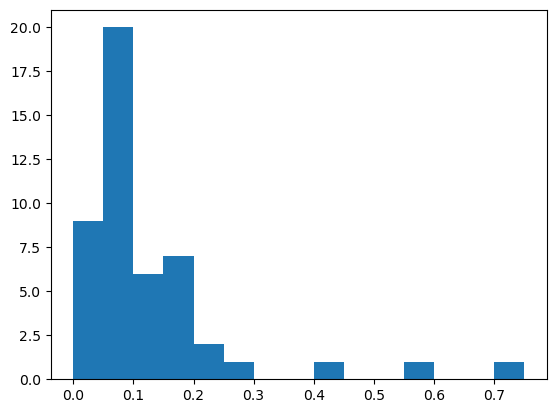

19/48 MDs from Xing 1 have a jaccard above 0.1


In [150]:
xing1_max_jacc = [top5_dict[c_md][0] for c_md in chosen_mds if c_md in top5_dict]
plt.hist(xing1_max_jacc, bins = np.arange(0,max(xing1_max_jacc)+0.05,0.05))
plt.show()
print("{}/{} MDs from Xing 1 have a jaccard above 0.1".format(len([1 for val in xing1_max_jacc if val>0.1]), len(xing1_max_jacc)))

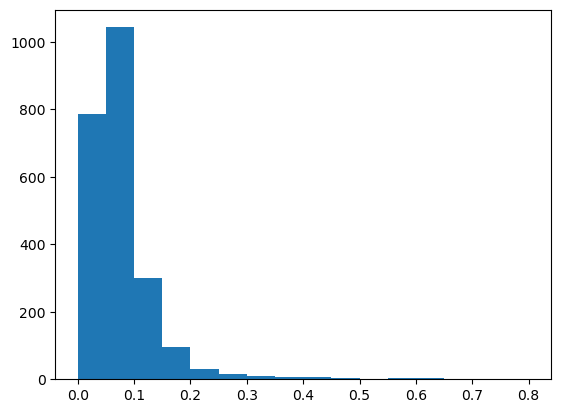

471/2306 MDs from Xing 1 have a jaccard above 0.1


In [152]:
xing2_max_jacc = [top5_dict[c_md][0] for c_md in chosen_mds if c_md in top5_dict]
plt.hist(xing2_max_jacc, bins = np.arange(0,max(xing2_max_jacc)+0.05,0.05))
plt.show()
print("{}/{} MDs from Xing 1 have a jaccard above 0.1".format(len([1 for val in xing2_max_jacc if val>0.1]), len(xing2_max_jacc)))

### Inspect chosen MDs

In [31]:
# load md documents
md_documents_filtered_file = os.path.join(data_path, all_pos + "_mass_difference_documents_filtered.pickle")
if os.path.exists(md_documents_filtered_file):
    with open(md_documents_filtered_file, 'rb') as inf:
        md_documents_filtered = pickle.load(inf)  # list of list of tuples 'documents'
    print(len(md_documents_filtered))
else:
    print("error")

115344


In [88]:
from collections import defaultdict

# dict of {md: [count for how many times it occurs in spectrumA, etc.]} for fitered data
per_md_counts_filtered = defaultdict(list)
for doc in md_documents_filtered:
    for tup in doc:
        per_md_counts_filtered[tup[0]].append(tup[2])
print("Number of mass differences left:", len(per_md_counts_filtered))

Number of mass differences left: 61348


In [114]:
md_spectrum_occurrences_filtered = {key:len(vals) for key, vals in per_md_counts_filtered.items()}
occurrences_filtered = md_spectrum_occurrences_filtered.values()

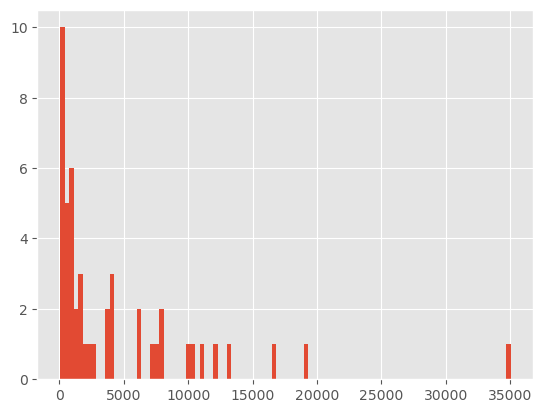

In [115]:
chosen_mds_occurrences = [md_spectrum_occurrences_filtered[c_md] for c_md in chosen_mds\
                          if c_md in md_spectrum_occurrences_filtered]
plt.hist(chosen_mds_occurrences, bins=100)
plt.show()

## Load processed spectra for cosine, s2v, s2v+MDs
Spectra processed for s2v, s2v+MD, cosine scoring are loaded from notebook 1.

In [5]:
# load top30 file
top30_file = os.path.join(data_path, all_pos + "_top30_peaks.pickle")
if os.path.exists(top30_file):
    with open(top30_file, 'rb') as inf:
        spectrums_top30 = pickle.load(inf)  # list of matchms.Spectrum.Spectrum
else:
    print("error")
# load processed file
processed_file = os.path.join(data_path, all_pos + "_processed.pickle")
if os.path.exists(processed_file):
    with open(processed_file, 'rb') as inf:
        spectrums_processed = pickle.load(inf)  # list of matchms.Spectrum.Spectrum
else:
    print("error")
# load classical file
classical_file = os.path.join(data_path, all_pos + "_classical.pickle")
if os.path.exists(classical_file):
    with open(classical_file, 'rb') as inf:
        spectrums_classical = pickle.load(inf)  # list of matchms.Spectrum.Spectrum
else:
    print("error")

### Correct a few (< 10) spectrums with missing precursor_mz
I should do this later still in notebook 1, as annotation history is not included in Spectrum.Spectrum anymore.

## Create test set of 1000 spectra whose inchikey exists in library >= 2 times

In [6]:
Inchikeys = []
for spec in spectrums_top30:
    Inchikeys.append(spec.get("inchikey"))
inchikeys_pd = pd.Series([x for x in Inchikeys if x])
inchikeys_pd.str[:14].value_counts()[:5]

NEGQHKSYEYVFTD    432
SULIDBRAXVDKBU    426
SRIGHEHXEGELQJ    338
IQGPMZRCLCCXAG    308
RWKUXQNLWDTSLO    235
dtype: int64

### Randomly select 1000 inchikeys that exist >=2 times in the dataset

In [7]:
min_copies_in_data = 2

suitable_inchikeys = pd.DataFrame(\
                                  inchikeys_pd.str[:14].value_counts()\
                                  [inchikeys_pd.str[:14].value_counts().values >= min_copies_in_data])
suitable_inchikeys.reset_index(level=suitable_inchikeys.index.names, inplace=True)
suitable_inchikeys.columns = (['inchikey14', 'occurences'])

# Important: sort values to make it reproducible (same occurences have random order otherwise!)
suitable_inchikeys = suitable_inchikeys.sort_values(['occurences', 'inchikey14'], ascending=False)

print(suitable_inchikeys.head(5))
print(suitable_inchikeys.tail(5))
print(f"Number of spectra with inchikeys that exist >= {min_copies_in_data} times:", suitable_inchikeys.shape[0])

       inchikey14  occurences
0  NEGQHKSYEYVFTD         432
1  SULIDBRAXVDKBU         426
2  SRIGHEHXEGELQJ         338
3  IQGPMZRCLCCXAG         308
4  RWKUXQNLWDTSLO         235
          inchikey14  occurences
7434  ABRULANJVVJLFI           2
7197  ABOPTWOWDLNBOE           2
7340  ABBPFXQJIWUCKF           2
8625  AAIIJIOWYALNCC           2
8517  AABZZWPMCAZHFC           2
Number of spectra with inchikeys that exist >= 2 times: 8686


In [8]:
num_spectra = 1000
np.random.seed(42) # to make it reproducible
selection = np.random.choice(suitable_inchikeys.shape[0], num_spectra, replace=False)
print(selection[:25])
selected_inchikeys = suitable_inchikeys['inchikey14'].values[selection]
selected_inchikeys[:25]

[6403 4224  604 2955 1385 5566  554 4331 3132 2318 2718 6744  538 6040
 1578 5652  733 6853 7816 5686 3133 1432 4819 3047 7162]


array(['HUSISCNTLUEZCN', 'LKUNZSUKADSCME', 'SEOVTRFCIGRIMH',
       'JVHNBFFHWQQPLL', 'XPUOZJJNPJXFTD', 'DTDSAWVUFPGDMX',
       'DAWYIZBOUQIVNX', 'DQNFLBXNPGBCOU', 'OOGZWXIAHJKVAH',
       'DOVSRUBRIYLZCI', 'HBOMLICNUCNMMY', 'ZOFBAJKPGIIQFN',
       'PADQINQHPQKXNL', 'QGLZXHRNAYXIBU', 'FMEUWIKCSICJBO',
       'BEHLQMQPYDCEFC', 'LZJRNLRASBVRRX', 'YGWFCQYETHJKNX',
       'LQQBKDRWDYGCBI', 'ZZRGFLVYILOXAK', 'OLBLWNPOURNBCY',
       'SYWHXTATXSMDSB', 'IKYICRRUVNIHPP', 'XRBIHOLQAKITPP',
       'UQIDVGMGKVCWIS'], dtype=object)

### Inspect number of library spectra with same InChIKey as queries

In [9]:
inchikeys14_array = np.array([x[:14] for x in Inchikeys if x is not None])
number_of_copies = []
for inchikey in selected_inchikeys:
    number_of_copies.append(len(np.where(inchikeys14_array == inchikey)[0]))

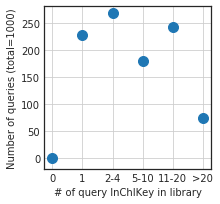

In [10]:
plt.figure(figsize=(3,3))
plt.style.use('seaborn-white')
bins = [0, 1.5, 2.5, 5.5, 11.5, 21.5, 101.5]
labels = ["0", "1", "2-4", "5-10", "11-20", ">20"]
a, b = np.histogram(number_of_copies, bins)
plt.scatter(labels, a, s=100)
plt.ylabel('Number of queries (total=1000)')
plt.xlabel('# of query InChIKey in library')
plt.ylim(-20)
plt.grid(True)
plt.show()
# plt.savefig("library_matching_scenario1_library_condition.svg")

### Randomly pick one spectra for each of the chosen inchikeys

In [11]:
selected_spectra = []
inchikeys_pd = pd.Series([x for x in Inchikeys]) #include all even empty ones to get the IDs right!
np.random.seed(42) # to make it reproducible
for inchikey in selected_inchikeys:
    matches = inchikeys_pd[inchikeys_pd.str[:14] == inchikey].index.values
    selected_spectra.append(int(np.random.choice(matches,1)[0]))

In [12]:
selected_spectra[:10]

[15197, 27760, 65359, 74062, 107581, 20577, 88075, 91020, 95033, 95625]

In [13]:
# Show gnps IDs for selected spectra
for ID in selected_spectra[:10]:
    print(spectrums_top30[ID].get("spectrumid"),
         spectrums_top30[ID].get("inchikey")[:14])

CCMSLIB00000852865 HUSISCNTLUEZCN
CCMSLIB00005464770 LKUNZSUKADSCME
CCMSLIB00000218947 SEOVTRFCIGRIMH
CCMSLIB00005746855 JVHNBFFHWQQPLL
CCMSLIB00004714612 XPUOZJJNPJXFTD
CCMSLIB00001058664 DTDSAWVUFPGDMX
CCMSLIB00000569990 DAWYIZBOUQIVNX
CCMSLIB00004692982 DQNFLBXNPGBCOU
CCMSLIB00004698130 OOGZWXIAHJKVAH
CCMSLIB00004698872 DOVSRUBRIYLZCI


## Train new model on AllPositive (2) without selected spectra
Two new models, one on 'normal' Spec2Vec and one with selected MDs added

In [14]:
from spec2vec import Spec2Vec
from spec2vec import SpectrumDocument

documents_library_processed = [SpectrumDocument(s, n_decimals=2) for i, s in enumerate(spectrums_processed) if i not in selected_spectra]
documents_library_classical = [SpectrumDocument(s, n_decimals=2) for i, s in enumerate(spectrums_classical) if i not in selected_spectra]
len(documents_library_processed), len(spectrums_processed)  # 1000 should be removed

(114344, 115344)

In [30]:
from spec2vec.model_building import train_new_word2vec_model

path_models = os.path.join(data_path, "trained_models")
model_file = os.path.join(path_models, all_pos+"_spec2vec_librarymatching_24-03.model")

iterations = [1, 3, 5, 10, 15, 20]
# Train model with default parameters
model = train_new_word2vec_model(documents_library_processed, iterations, model_file)

  Epoch 1 of 20.Change in loss after epoch 1: 6120857.5
Saving model with name: /mnt/scratch/louwe015/Mass_differences/data/trained_models/ALL_GNPS_210125_positive_cleaned_by_matchms_and_lookups_spec2vec_librarymatching_24-03_iter_1.model
  Epoch 2 of 20.Change in loss after epoch 2: 4557735.5
  Epoch 3 of 20.Change in loss after epoch 3: 4054406.0
Saving model with name: /mnt/scratch/louwe015/Mass_differences/data/trained_models/ALL_GNPS_210125_positive_cleaned_by_matchms_and_lookups_spec2vec_librarymatching_24-03_iter_3.model
  Epoch 4 of 20.Change in loss after epoch 4: 3615177.0
  Epoch 5 of 20.Change in loss after epoch 5: 3170450.0
Saving model with name: /mnt/scratch/louwe015/Mass_differences/data/trained_models/ALL_GNPS_210125_positive_cleaned_by_matchms_and_lookups_spec2vec_librarymatching_24-03_iter_5.model
  Epoch 6 of 20.Change in loss after epoch 6: 2994854.0
  Epoch 7 of 20.Change in loss after epoch 7: 2939582.0
  Epoch 8 of 20.Change in loss after epoch 8: 2809522.0
  E

## Add MDs to spectrum documents
Load MD documents (notebook 1), and select selected spectra.

Then add new words as 'md@...'. Intensity (for now) is sqrt(count) * max_intensity with a maximum of 1.

In [15]:
# Load MD documents
md_documents_file = os.path.join(data_path, all_pos + "_mass_difference_documents.pickle")
if os.path.exists(md_documents_file):
    with open(md_documents_file, 'rb') as inf:
        md_documents = pickle.load(inf)  # list of list of tuples 'documents'
    print(len(md_documents))
else:
    print("error")

115344


In [154]:
documents_library_mds = [md_doc for i, md_doc in enumerate(md_documents) if i not in selected_spectra]
len(documents_library_mds), len(md_documents)  # 1000 should be removed

(114344, 115344)

In [155]:
def convert_md_tup(md_tup: Tuple[str, List[float], int],
                   count_multiplier: bool = True,
                   punish: bool = False) -> Tuple[str, float]:
    """Convert md_tup to (word, intensity)
    
    md_tup:
        The tuple containing info for one MD in a MD document
    """
    word = f"md@{md_tup[0]}"
    intensity = max(md_tup[1])
    if punish:
        intensity = intensity/2
    if count_multiplier:
        intensity = intensity*np.sqrt(md_tup[2])
    if intensity > 1:
        intensity = 1.0
    return (word, intensity)

In [156]:
documents_library_processed_with_mds = []
set_chosen_mds = set(chosen_mds)
c_multiply = True  # multiply intensities with sqrt of count
punish_ints = True
for doc, md_doc in zip(documents_library_processed, documents_library_mds):
    new_doc = deepcopy(doc)  # make sure original doc is not affected
    
    processed_mds = [convert_md_tup(md, count_multiplier=c_multiply, punish=punish_ints)\
                     for md in md_doc if md[0] in set_chosen_mds]
    if processed_mds:
        md_words, md_intensities = zip(*processed_mds)
        new_doc.words.extend(md_words)
        new_doc.weights.extend(md_intensities)
    assert len(new_doc.words) == len(new_doc.weights)
    
    documents_library_processed_with_mds.append(new_doc)

In [131]:
len(documents_library_processed_with_mds) # check

114344

### Inspect MDs in documents

In [132]:
total_words = []
non_md_words = []
md_words = []
non_md_avg_intensity = []
md_avg_intensity = []

for doc in documents_library_processed_with_mds:
    words = doc.words
    total_w = len(words)
    md_len = len([1 for w in words if w.startswith('md')])
    non_md_len = total_w - md_len
    md_ints = []
    non_md_ints = []
    for w, i in zip(doc.words, doc.weights):
        if w.startswith('md'):
            md_ints.append(i)
        else:
            non_md_ints.append(i)
    if not md_ints:  # when there are no mds in a spectrum
        md_ints = [0]
    non_md_avg_intensity.append(np.mean(non_md_ints))
    md_avg_intensity.append(np.mean(md_ints))
    total_words.append(total_w)
    non_md_words.append(non_md_len)
    md_words.append(md_len)

Text(0, 0.5, 'MDs per spectrum')

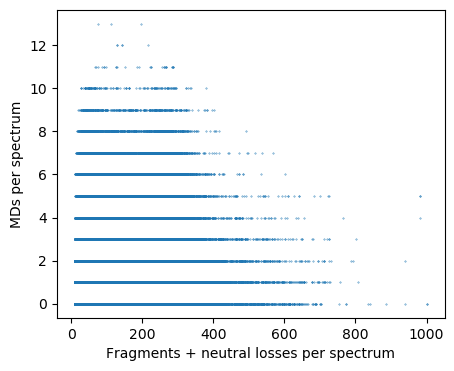

In [121]:
# plt.style.use('default')
# plt.figure(figsize=(5,4))
plt.scatter(non_md_words, md_words, s=0.1)
plt.xlabel('Fragments + neutral losses per spectrum')
plt.ylabel('MDs per spectrum')

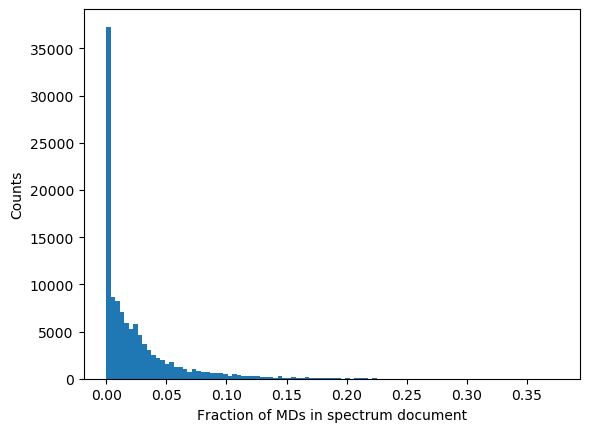

In [122]:
md_tot_frac = [md_l/tot_l for md_l, tot_l in zip(md_words, total_words)]
plt.hist(md_tot_frac, bins=100)
plt.xlabel('Fraction of MDs in spectrum document')
plt.ylabel('Counts')
plt.show()

[0.06467584312219177, 0.03158024118382469, 0.053079693588676376, 0.06259834235391674, 0.04504982920292901] [0.0, 0.0, 0.0, 0.0, 0.2951642750906948]


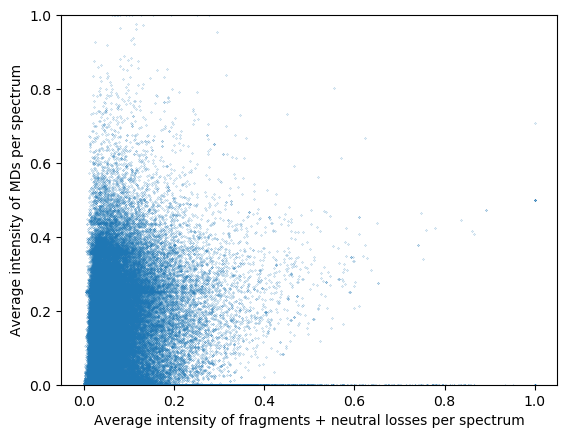

In [133]:
print(non_md_avg_intensity[:5], md_avg_intensity[:5])
plt.scatter(non_md_avg_intensity, md_avg_intensity, s=0.03)
plt.xlabel('Average intensity of fragments + neutral losses per spectrum')
plt.ylabel('Average intensity of MDs per spectrum')
plt.ylim((0,1))
plt.show()

## Train new model on AllPositive (2) with added MDs, without selected spectra

In [100]:
from spec2vec.model_building import train_new_word2vec_model

path_models = os.path.join(data_path, "trained_models")
model_file_mds = os.path.join(path_models, all_pos+"_spec2vec_librarymatching_added_MDs_xing2_31-03.model")

iterations = [1, 3, 5, 10, 15, 20]
# Train model with default parameters
model_mds = train_new_word2vec_model(documents_library_processed_with_mds, iterations, model_file_mds)

  Epoch 1 of 20.Change in loss after epoch 1: 7024848.5
Saving model with name: /mnt/scratch/louwe015/Mass_differences/data/trained_models/ALL_GNPS_210125_positive_cleaned_by_matchms_and_lookups_spec2vec_librarymatching_added_MDs_xing2_31-03_iter_1.model
  Epoch 2 of 20.Change in loss after epoch 2: 5273212.5
  Epoch 3 of 20.Change in loss after epoch 3: 4752207.0
Saving model with name: /mnt/scratch/louwe015/Mass_differences/data/trained_models/ALL_GNPS_210125_positive_cleaned_by_matchms_and_lookups_spec2vec_librarymatching_added_MDs_xing2_31-03_iter_3.model
  Epoch 4 of 20.Change in loss after epoch 4: 3927310.0
  Epoch 5 of 20.Change in loss after epoch 5: 3858164.0
Saving model with name: /mnt/scratch/louwe015/Mass_differences/data/trained_models/ALL_GNPS_210125_positive_cleaned_by_matchms_and_lookups_spec2vec_librarymatching_added_MDs_xing2_31-03_iter_5.model
  Epoch 6 of 20.Change in loss after epoch 6: 3702238.0
  Epoch 7 of 20.Change in loss after epoch 7: 3607692.0
  Epoch 8 o

## Do library matching 'normal' Spec2Vec and classical
precursor m/z tolerance = 1ppm

In [42]:
base_path = os.path.split(data_path[:-1])[0]
# from https://github.com/iomega/spec2vec_gnps_data_analysis
florians_custom_funcs = os.path.join(base_path, 'spec2vec_gnps_data_analysis', 'custom_functions')
sys.path.insert(0, florians_custom_funcs)
from library_search import library_matching

In [43]:
path_models = os.path.join(data_path, "trained_models")
model_file = os.path.join(path_models, all_pos+"_spec2vec_librarymatching_24-03_iter_15.model")
model = gensim.models.Word2Vec.load(model_file)
print(model)

Word2Vec(vocab=115911, size=300, alpha=0.025)


In [44]:
documents_query_processed = [SpectrumDocument(spectrums_processed[i], n_decimals=2) for i in selected_spectra]
documents_query_classical = [SpectrumDocument(spectrums_classical[i], n_decimals=2) for i in selected_spectra]
print(len(documents_query_processed))

1000


In [45]:
tstart = time.time()
found_matches_processed = library_matching(documents_query_processed, documents_library_processed,
                                         model,
                                         presearch_based_on=["precursor_mz", "spec2vec-top20"],
                                         include_scores=["cosine", "modcosine"],
                                         ignore_non_annotated=True,
                                         intensity_weighting_power=0.5,
                                         allowed_missing_percentage=50.0,
                                         cosine_tol=0.005,
                                         mass_tolerance=1.0,
                                         mass_tolerance_type="ppm")

tend = time.time()
print(f"Library matching took {(tend-tstart):.2f} s.")

Calculating vectors of reference spectrums:   0%|          | 0/95290 [00:00<?, ?it/s]

Pre-selection includes spec2vec top 20.


Calculating vectors of query spectrums:  58%|█████▊    | 576/1000 [00:00<00:00, 1437.86it/s]

Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.21%.


Calculating vectors of query spectrums:  89%|████████▉ | 891/1000 [00:00<00:00, 1456.13it/s]

Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.14%.


Calculating vectors of query spectrums: 100%|██████████| 1000/1000 [00:00<00:00, 1457.05it/s]


Pre-selection includes mass matches within 1.0 ppm.


  0%|          | 0/1000 [00:00<?, ?it/s]

Calculate cosine score for selected candidates.
Calculate modified cosine score for selected candidates.


100%|██████████| 1000/1000 [00:14<00:00, 70.97it/s]

Library matching took 91.59 s.


In [46]:
tstart = time.time()
found_matches_classical = library_matching(documents_query_classical, documents_library_classical,
                                           model,
                                           presearch_based_on=["precursor_mz"],
                                           include_scores=["cosine", "modcosine"],
                                           ignore_non_annotated=True,
                                           intensity_weighting_power=0.5,
                                           allowed_missing_percentage=50.0,
                                           cosine_tol=0.005,
                                           mass_tolerance=1.0,
                                           mass_tolerance_type="ppm")
tend = time.time()
print(f"Library matching took {(tend-tstart):.2f} s.")

Pre-selection includes mass matches within 1.0 ppm.


  0%|          | 0/1000 [00:00<?, ?it/s]

Calculate cosine score for selected candidates.
Calculate modified cosine score for selected candidates.


100%|██████████| 1000/1000 [00:09<00:00, 108.45it/s]

Library matching took 11.20 s.


In [47]:
len(found_matches_processed), len(found_matches_classical)

(1000, 1000)

In [48]:
found_matches_processed[1].sort_values(by="s2v_score", ascending=False).iloc[:5]

,cosine_score,cosine_matches,mod_cosine_score,mod_cosine_matches,mass_match,s2v_score
27394,0.8822231222965523,144,0.8822231222965523,144,True,0.909247
27414,0.8401839173932139,102,0.8401839173932139,102,True,0.884243
27644,0.7375993664626038,130,0.7375993664626038,130,True,0.849660
27352,0.9220880795783896,97,0.9220880795783896,97,True,0.841875
27263,0.31238366368556064,122,0.7140814880386975,131,False,0.794149


## Do library matching Spec2Vec including MDs
precursor m/z tolerance = 1ppm


In [49]:
documents_query_mds = [md_doc for i, md_doc in enumerate(md_documents) if i in selected_spectra]
len(documents_query_mds)

1000

In [157]:
documents_query_processed_with_mds = []
set_chosen_mds = set(chosen_mds)
for doc, md_doc in zip(documents_query_processed, documents_query_mds):
    new_doc = deepcopy(doc)  # make sure original doc is not affected
    
    processed_mds = [convert_md_tup(md) for md in md_doc if md[0] in set_chosen_mds]
    if processed_mds:
        md_words, md_intensities = zip(*processed_mds)
        new_doc.words.extend(md_words)
        new_doc.weights.extend(md_intensities)
    assert len(new_doc.words) == len(new_doc.weights)
    
    documents_query_processed_with_mds.append(new_doc)

In [158]:
path_models = os.path.join(data_path, "trained_models")
md_version = '_added_MDs_xing1_31-03_iter_15'
model_file_mds = os.path.join(path_models, f"{all_pos}_spec2vec_librarymatching{md_version}.model")
model_mds = gensim.models.Word2Vec.load(model_file_mds)
print(model_mds)

Word2Vec(vocab=115959, size=300, alpha=0.025)


In [159]:
tstart = time.time()
found_matches_processed_with_mds = library_matching(documents_query_processed_with_mds, documents_library_processed_with_mds,
                                         model_mds,
                                         presearch_based_on=["precursor_mz", "spec2vec-top20"],
                                         include_scores=["cosine", "modcosine"],
                                         ignore_non_annotated=True,
                                         intensity_weighting_power=0.5,
                                         allowed_missing_percentage=50.0,
                                         cosine_tol=0.005,
                                         mass_tolerance=1.0,
                                         mass_tolerance_type="ppm")

tend = time.time()
print(f"Library matching took {(tend-tstart):.2f} s.")

Calculating vectors of reference spectrums:   0%|          | 166/95290 [00:00<00:57, 1650.69it/s]

Pre-selection includes spec2vec top 20.


Calculating vectors of query spectrums:  57%|█████▋    | 567/1000 [00:00<00:00, 1416.38it/s]

Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.21%.


Calculating vectors of query spectrums:  88%|████████▊ | 881/1000 [00:00<00:00, 1420.22it/s]

Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.14%.


Calculating vectors of query spectrums: 100%|██████████| 1000/1000 [00:00<00:00, 1434.05it/s]


Pre-selection includes mass matches within 1.0 ppm.


  1%|          | 9/1000 [00:00<00:11, 86.90it/s]

Calculate cosine score for selected candidates.
Calculate modified cosine score for selected candidates.


100%|██████████| 1000/1000 [00:12<00:00, 81.75it/s]

Library matching took 81.50 s.


In [104]:
len(found_matches_processed_with_mds)

1000

In [160]:
found_matches_processed_with_mds[0].sort_values(by="s2v_score", ascending=False).iloc[:5]

,cosine_score,cosine_matches,mod_cosine_score,mod_cosine_matches,mass_match,s2v_score
27744,0.0,0,0.9920166592128264,3,False,0.628781
28240,0.0,0,0.0,0,False,0.586328
27594,0.0,0,0.0,0,False,0.574876
28052,0.0,0,0.0,0,False,0.574485
62964,0.0,0,0.0,0,False,0.540566


In [161]:
# How many results have a higher score with +MD?
comps = []
for without_mds, with_mds in zip(found_matches_processed, found_matches_processed_with_mds):
    without_max = without_mds.sort_values(by="s2v_score", ascending=False).iloc[0]["s2v_score"]
    with_max = with_mds.sort_values(by="s2v_score", ascending=False).iloc[0]["s2v_score"]
    comps.append(with_max - without_max)
np.mean(comps), len([comp for comp in comps if comp>=0])

(-0.0736232884833756, 116)

## Evaluate different similarity scoring methods
In order:
- Cosine min_match=2
- Cosine min_match=6
- Spec2Vec 'normal'
- Spec2Vec with MDs

In [162]:
min_match = 2
cosine_thresholds = np.arange(0, 1, 0.05)

test_matches_min2 = []
for threshold in cosine_thresholds:
    print(f"Checking matches for cosine score > {threshold:.2f}")
    test_matches = []
    
    for ID in range(len(documents_query_classical)):
        if len(found_matches_classical[ID]) > 0:
            # Scenario 1: mass + sort by cosine
            df_select = found_matches_classical[ID][(found_matches_classical[ID]['mass_match'] == 1)
                                         & (found_matches_classical[ID]['cosine_score'] > threshold)
                                         & (found_matches_classical[ID]['cosine_matches'] >= min_match)]

            if df_select.shape[0] > 0:
                best_match_ID = df_select.sort_values(by=['cosine_score'], ascending=False).index[0]
                inchikey_selected = documents_library_classical[best_match_ID]._obj.get("inchikey")[:14]
                inchikey_query = documents_query_classical[ID]._obj.get("inchikey")[:14]

                best_bet = 1 * (inchikey_selected == inchikey_query)
            else:
                best_bet = -1 # meaning: not found
            test_matches.append(best_bet)

    # Make arrays from lists:
    test_arr = np.array(test_matches)

    test_matches_min2.append([np.sum(test_arr == 1), np.sum(test_arr == 0), np.sum(test_arr == -1)])

Checking matches for cosine score > 0.00
Checking matches for cosine score > 0.05
Checking matches for cosine score > 0.10
Checking matches for cosine score > 0.15
Checking matches for cosine score > 0.20
Checking matches for cosine score > 0.25
Checking matches for cosine score > 0.30
Checking matches for cosine score > 0.35
Checking matches for cosine score > 0.40
Checking matches for cosine score > 0.45
Checking matches for cosine score > 0.50
Checking matches for cosine score > 0.55
Checking matches for cosine score > 0.60
Checking matches for cosine score > 0.65
Checking matches for cosine score > 0.70
Checking matches for cosine score > 0.75
Checking matches for cosine score > 0.80
Checking matches for cosine score > 0.85
Checking matches for cosine score > 0.90
Checking matches for cosine score > 0.95


In [163]:
min_match = 6
cosine_thresholds = np.arange(0, 1, 0.05)

test_matches_min6 = []
for threshold in cosine_thresholds:
    print(f"Checking matches for cosine score > {threshold:.2f}")
    test_matches = []
    
    for ID in range(len(documents_query_classical)):
        if len(found_matches_classical[ID]) > 0:
            # Scenario 1: mass + sort by cosine
            df_select = found_matches_classical[ID][(found_matches_classical[ID]['mass_match'] == 1)
                                             & (found_matches_classical[ID]['cosine_score'] > threshold)
                                             & (found_matches_classical[ID]['cosine_matches'] >= min_match)]

            if df_select.shape[0] > 0:
                best_match_ID = df_select.sort_values(by=['cosine_score'], ascending=False).index[0]
                inchikey_selected = documents_library_classical[best_match_ID]._obj.get("inchikey")[:14]
                inchikey_query = documents_query_classical[ID]._obj.get("inchikey")[:14]

                best_bet = 1 * (inchikey_selected == inchikey_query)
            else:
                best_bet = -1 # meaning: not found
            test_matches.append(best_bet)

    # Make arrays from lists:
    test_arr = np.array(test_matches)
    
    test_matches_min6.append([np.sum(test_arr == 1), np.sum(test_arr == 0), np.sum(test_arr == -1)])

Checking matches for cosine score > 0.00
Checking matches for cosine score > 0.05
Checking matches for cosine score > 0.10
Checking matches for cosine score > 0.15
Checking matches for cosine score > 0.20
Checking matches for cosine score > 0.25
Checking matches for cosine score > 0.30
Checking matches for cosine score > 0.35
Checking matches for cosine score > 0.40
Checking matches for cosine score > 0.45
Checking matches for cosine score > 0.50
Checking matches for cosine score > 0.55
Checking matches for cosine score > 0.60
Checking matches for cosine score > 0.65
Checking matches for cosine score > 0.70
Checking matches for cosine score > 0.75
Checking matches for cosine score > 0.80
Checking matches for cosine score > 0.85
Checking matches for cosine score > 0.90
Checking matches for cosine score > 0.95


In [164]:
test_matches_s2v = []

cosine_thresholds = np.arange(0,1,0.05)

for threshold in cosine_thresholds:
    print(f"Checking matches for spec2vec score > {threshold:.2f}")
    test_matches = []
    
    for ID in range(len(documents_query_processed)):

        # Scenario 2: mass + sort by Spec2Vec
        df_select = found_matches_processed[ID][(found_matches_processed[ID]['mass_match'] == 1)
                                      & (found_matches_processed[ID]['s2v_score'] > threshold)]
        if df_select.shape[0] > 0:
            best_match_ID = df_select.sort_values(by=['s2v_score'], ascending=False).index[0]
            inchikey_selected = documents_library_processed[best_match_ID]._obj.get("inchikey")[:14]
            inchikey_query = documents_query_processed[ID]._obj.get("inchikey")[:14]
            
            best_bet = 1 * (inchikey_selected == inchikey_query)
        else:
            best_bet = -1 # meaning: not found
        test_matches.append(best_bet)

    # Make arrays from lists:
    test_arr = np.array(test_matches)
    
    test_matches_s2v.append([np.sum(test_arr == 1), np.sum(test_arr == 0), np.sum(test_arr == -1)])

Checking matches for spec2vec score > 0.00
Checking matches for spec2vec score > 0.05
Checking matches for spec2vec score > 0.10
Checking matches for spec2vec score > 0.15
Checking matches for spec2vec score > 0.20
Checking matches for spec2vec score > 0.25
Checking matches for spec2vec score > 0.30
Checking matches for spec2vec score > 0.35
Checking matches for spec2vec score > 0.40
Checking matches for spec2vec score > 0.45
Checking matches for spec2vec score > 0.50
Checking matches for spec2vec score > 0.55
Checking matches for spec2vec score > 0.60
Checking matches for spec2vec score > 0.65
Checking matches for spec2vec score > 0.70
Checking matches for spec2vec score > 0.75
Checking matches for spec2vec score > 0.80
Checking matches for spec2vec score > 0.85
Checking matches for spec2vec score > 0.90
Checking matches for spec2vec score > 0.95


In [165]:
test_matches_s2v_mds = []

cosine_thresholds = np.arange(0,1,0.05)

for threshold in cosine_thresholds:
    print(f"Checking matches for spec2vec score > {threshold:.2f}")
    test_matches = []
    
    for ID in range(len(documents_query_processed_with_mds)):

        # Scenario 2: mass + sort by Spec2Vec
        df_select = found_matches_processed_with_mds[ID][(found_matches_processed_with_mds[ID]['mass_match'] == 1)
                                      & (found_matches_processed_with_mds[ID]['s2v_score'] > threshold)]
        if df_select.shape[0] > 0:
            best_match_ID = df_select.sort_values(by=['s2v_score'], ascending=False).index[0]
            inchikey_selected = documents_library_processed_with_mds[best_match_ID]._obj.get("inchikey")[:14]
            inchikey_query = documents_query_processed_with_mds[ID]._obj.get("inchikey")[:14]
            
            best_bet = 1 * (inchikey_selected == inchikey_query)
        else:
            best_bet = -1 # meaning: not found
        test_matches.append(best_bet)

    # Make arrays from lists:
    test_arr = np.array(test_matches)
    
    test_matches_s2v_mds.append([np.sum(test_arr == 1), np.sum(test_arr == 0), np.sum(test_arr == -1)])

Checking matches for spec2vec score > 0.00
Checking matches for spec2vec score > 0.05
Checking matches for spec2vec score > 0.10
Checking matches for spec2vec score > 0.15
Checking matches for spec2vec score > 0.20
Checking matches for spec2vec score > 0.25
Checking matches for spec2vec score > 0.30
Checking matches for spec2vec score > 0.35
Checking matches for spec2vec score > 0.40
Checking matches for spec2vec score > 0.45
Checking matches for spec2vec score > 0.50
Checking matches for spec2vec score > 0.55
Checking matches for spec2vec score > 0.60
Checking matches for spec2vec score > 0.65
Checking matches for spec2vec score > 0.70
Checking matches for spec2vec score > 0.75
Checking matches for spec2vec score > 0.80
Checking matches for spec2vec score > 0.85
Checking matches for spec2vec score > 0.90
Checking matches for spec2vec score > 0.95


## Plot evaluation results

Text(0, 0.5, 'true positive rate')

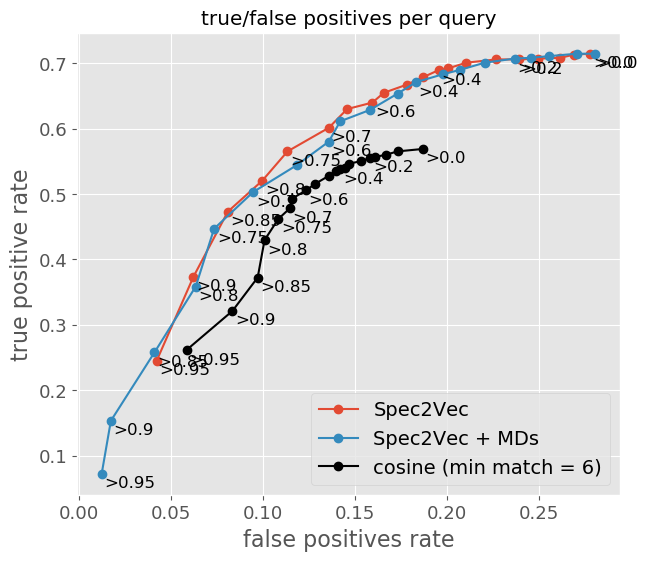

In [166]:
min_match = 6
#test_matches_cosine_arr = np.array(test_matches_ROC_min2)

test_matches_cosine_arr = np.array(test_matches_min6)
test_matches_s2v_arr = np.array(test_matches_s2v)
test_matches_s2v_mds_arr = np.array(test_matches_s2v_mds)

thresholds = np.arange(0, 1, 0.05)
label_picks = [0,4,8,12,14,15,16,17,18,19]

plt.figure(figsize=(7,6))
plt.style.use('ggplot')
num_max = np.sum(test_matches_cosine_arr[0,:])

plt.plot(test_matches_s2v_arr[:,1]/num_max, test_matches_s2v_arr[:,0]/num_max, 
         'o-', label='Spec2Vec')
plt.plot(test_matches_s2v_mds_arr[:,1]/num_max, test_matches_s2v_mds_arr[:,0]/num_max, 
         'o-', label='Spec2Vec + MDs')
plt.plot(test_matches_cosine_arr[:,1]/num_max, test_matches_cosine_arr[:,0]/num_max, 
         'o-', color='black', label='cosine (min match = {})'.format(min_match))
for i, threshold in enumerate(thresholds):
    if i in label_picks:
        plt.annotate(">{:.2}".format(threshold),
                    (test_matches_s2v_arr[i,1]/num_max, test_matches_s2v_arr[i,0]/num_max),
                    textcoords="offset points", xytext=(2,-10), fontsize=12)
        plt.annotate(">{:.2}".format(threshold),
                    (test_matches_s2v_mds_arr[i,1]/num_max, test_matches_s2v_mds_arr[i,0]/num_max),
                    textcoords="offset points", xytext=(2,-10), fontsize=12)
        plt.annotate(">{:.2}".format(threshold),
                    (test_matches_cosine_arr[i,1]/num_max, test_matches_cosine_arr[i,0]/num_max),
                    textcoords="offset points", xytext=(2,-10), fontsize=12)

#plt.plot(test_matches_ROC_min2_arr[:,1]/num_max, test_matches_ROC_min2_arr[:,0]/num_max, 
#         '.--', color='black', alpha=0.5, label='cosine (min match = 2)')

plt.title('true/false positives per query')
plt.legend(fontsize=14)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.xlabel('false positives rate', fontsize=16)
plt.ylabel('true positive rate', fontsize=16)
#plt.xlim([0, 0.3])
# plt.savefig(os.path.join(data_path, 'figures', f'library_matching_true_false_positives_labeled_{md_version}.svg'))

Text(0, 0.5, 'accuracy (% correct hits)')

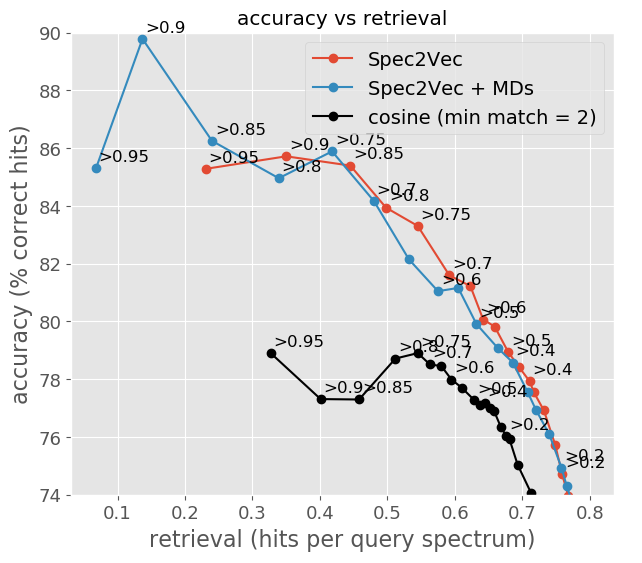

In [167]:
min_match=2
test_matches_cosine_arr = np.array(test_matches_min2)
#test_matches_cosine_arr = np.array(test_matches_min6)
test_matches_s2v_arr = np.array(test_matches_s2v)
test_matches_s2v_mds_arr = np.array(test_matches_s2v_mds)

thresholds = np.arange(0, 1, 0.05)
label_picks = [0,4,8,10,12,14,15,16,17,18,19]

accuracy_s2v = 100 * test_matches_s2v_arr[:,0]/(test_matches_s2v_arr[:,0] + test_matches_s2v_arr[:,1])
accuracy_s2v_mds = 100 * test_matches_s2v_mds_arr[:,0]/(test_matches_s2v_mds_arr[:,0] + test_matches_s2v_mds_arr[:,1])
accuracy_cosine = 100 * test_matches_cosine_arr[:,0]/(test_matches_cosine_arr[:,0] + test_matches_cosine_arr[:,1])

retrieval_s2v = (test_matches_s2v_arr[:,1] + test_matches_s2v_arr[:,0])/1000
retrieval_s2v_mds = (test_matches_s2v_mds_arr[:,1] + test_matches_s2v_mds_arr[:,0])/1000
retrieval_cosine = (test_matches_cosine_arr[:,1] + test_matches_cosine_arr[:,0])/1000

plt.figure(figsize=(7,6))
plt.style.use('ggplot')
plt.plot(retrieval_s2v, accuracy_s2v, 'o-', label='Spec2Vec')
plt.plot(retrieval_s2v_mds, accuracy_s2v_mds, 'o-', label='Spec2Vec + MDs')
plt.plot(retrieval_cosine, accuracy_cosine, 'o-', color="black", label='cosine (min match = {})'.format(min_match))

for i, threshold in enumerate(thresholds):
    if i in label_picks:
        plt.annotate(">{:.2}".format(threshold),
                    (retrieval_s2v[i], accuracy_s2v[i]),
                    textcoords="offset points", xytext=(2, 5), fontsize=12)
        plt.annotate(">{:.2}".format(threshold),
                    (retrieval_s2v_mds[i], accuracy_s2v_mds[i]),
                    textcoords="offset points", xytext=(2, 5), fontsize=12)
        plt.annotate(">{:.2}".format(threshold),
                    (retrieval_cosine[i], accuracy_cosine[i]),
                    textcoords="offset points", xytext=(2, 5), fontsize=12)

plt.title('accuracy vs retrieval')
plt.legend(fontsize=14)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.ylim([74, 90])
plt.xlabel('retrieval (hits per query spectrum)', fontsize=16)
plt.ylabel('accuracy (% correct hits)', fontsize=16)
# plt.savefig(os.path.join(data_path, 'figures', f'library_matching_accuracy_vs_retrieval_minmatch2_{md_version}.svg'))
# plt.show()